# Adiabatic Tests

This notebook compares the analytical estimates from the literature for changes to a binary system's energy, eccentricity, and inclination to the n-body integrations of `REBOUND`. This notebook provides evidence for the justification of some of the implementation details found within `AIRBALL`, such as `rmax` and `maximum_impact_parameter`.

We begin by importing everything we'll need for running the stellar flybys and for making good-looking figures.

In [1]:
import rebound
import airball
import airball.units as u
from airball.tools import moving_average as ma

import numpy as np
import joblib
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

import matplotlib.style as style
style.use('tableau-colorblind10')

#### Define constants and parameters
We also define some useful constants and parameters for setting up our system. We take the current values of Neptune's orbital elements but will first consider the planar case. Additionally, we pick a set of parameters for our stellar flyby as a specific example.

In [2]:
pi = np.pi
twopi = 2.*pi

sun_mass = 1.0 * u.solMass # Msun

# Basic orbital elements of Neptune
planet_mass = 5.15e-05 * u.solMass
planet_a = 30.278 * u.au
planet_e = 0.0130 * u.dimensionless_unscaled
# More if you don't want Neptune to be planar.
planet_inc = 0.031 * u.rad
planet_omega = 4.338 * u.rad
planet_Omega = 2.299 * u.rad

# Set the orbital elements of the flyby star
# Simulate a randomly oriented, 1 solar mass stellar flyby with relative velocity of 5 km/s, and an impact parameter of 100 AU.
star = airball.Star(m = 1 * u.solMass, b = 125 * u.au, v = 5 * u.km/u.s, inc = 1.12 * u.rad, omega = 1.09 * u.rad, Omega = 0.97 * u.rad)
print('star.inc:   {0:7.2f}'.format(star.inc.to(u.deg)))
print('star.omega: {0:7.2f}'.format(star.omega.to(u.deg)))
print('star.Omega: {0:7.2f}'.format(star.Omega.to(u.deg)))

star.inc:     64.17 deg
star.omega:   62.45 deg
star.Omega:   55.58 deg


#### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility.

In [3]:
def setup(planet_mass=5.151383772628674e-05*u.solMass, planet_a=30.27762143269065*u.au, planet_e=0.012971767987242259 * u.dimensionless_unscaled, planet_inc=0*u.rad, planet_omega=0*u.rad, planet_Omega=0*u.rad, planet_f=0*u.rad):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=sun_mass.value)
    sim.add(m=planet_mass.value, a=planet_a.value, e=planet_e.value, inc=planet_inc.value, omega=planet_omega.value, Omega=planet_Omega.value, f=planet_f.value)
    sim.integrator = 'whckl'
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.01 * sim.particles[1].P
    sim.move_to_com()
    return sim

sim = setup()

## The Adiabatic Regime

The adiabatic regime for changes to the energy, eccentricity, and inclination of a binary system due to a stellar flyby is generally defined when $q \gg a$, $v_\mathrm{inf} \sim v_\mathrm{planet}$, and for similarly massive objects, i.e. $m_1 \sim m_2 \sim m_3$. These assumptions are made in the perturbative analysis for coming up with analytic expressions (see the grey regime on the right side of the figure below), but comparisons to n-body results show that these boundaries can be pushed a little.

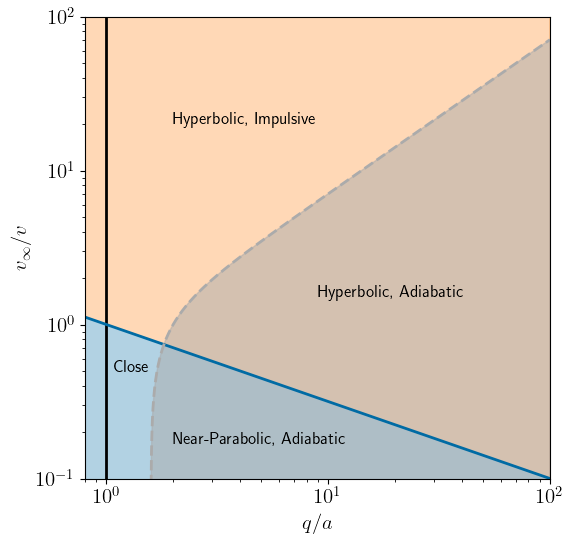

In [4]:
N = int(1e5)
qbya = np.logspace(-1, 2, N)
vinfbyv = np.logspace(-1, 2, N)

plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.axvline(1, c='k', ls='-', lw=2)
parabolic = 1./np.sqrt(qbya)
ax.loglog(qbya, parabolic, 'C0', lw=2)
ax.fill_between(qbya, parabolic, color='C0', alpha=0.3)
hyperbolic = 1./np.sqrt(qbya)
ax.fill_between(qbya, hyperbolic, 100, color='C1', alpha=0.3)
adiabatic = np.sqrt(2.)*(qbya[qbya >= 2**(2/3)])*np.sqrt(0.25-(qbya[qbya >= 2**(2/3)])**(-3))
ax.loglog(qbya[qbya >= 2**(2/3)], adiabatic, 'C2--', lw=2)
ax.fill_between(qbya[qbya >= 2**(2/3)], adiabatic, color='C2', alpha=0.5)

ax.text(2, 20, "Hyperbolic, Impulsive", {'size': 12})
ax.text(9, 1.5, "Hyperbolic, Adiabatic", {'size': 12})
ax.text(2, 0.17, "Near-Parabolic, Adiabatic", {'size': 12})
ax.text(1.085, 0.5, "Close", {'size': 12})

ax.set_xlabel(r'$q/a$')
ax.set_ylabel(r'$v_\infty/v$')
ax.set_xlim([0.8, 1e2])
ax.set_ylim([1e-1, 1e2])
plt.show()

Analytic estimates for changes to the energy, eccentricity, and inclination of a binary system from a stellar flyby depend nonlinearly on the relationships between the perihelion and relative velocity of the flyby star. This notebook compares analytical estimates from the literature to n-body integrations. As is shown below, the analytical estimates match n-body results really well within the specified regimes, and in some cases beyond the regimes. Even though most of the analytical theory has been developed for stellar mass binary systems and stellar flybys, the match between theory and numerical results remains suprisingly close even for planetary systems.

## Implementation Details

We found that when probing changes to a system from an adiabatic flyby, it is important to begin with the star around $r_\mathrm{max} \sim \mathcal{O}(10^5\,\mathrm{AU})$ away from the Sun.

## Investigate the effects from a flyby with respect to perihelion.

The effects of a stellar flyby on star-planet energy depends exponentially on the perihelion distance. There is a power-law dependence on the effect of a stellar flyby on the eccentricity of a star-planet system. We can investigate this by running a couple hundred flyby scenarios while systematically changing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.

The following takes about 10 seconds to run on an M2 Pro Macbook Pro

In [5]:
Nflybys = 500

star_qs = np.logspace(-1, 4, Nflybys) * planet_a
qda = star_qs/planet_a
star_bs = airball.tools.vinf_and_q_to_b(mu = airball.tools.gravitational_mu(sim, star), star_q = star_qs, star_v=star.v)
stars = airball.Stars(m=star.m, b=star_bs, v=star.v)
RMAX = 4.5e5 * u.au

sims = [setup() for i in range(Nflybys)]
sim_results = airball.flybys(sims, stars, hybrid=True, rmax=RMAX, overwrite=False)

est_dE = np.abs(airball.analytic.relative_energy_change(setup(), stars))
est_de = np.abs(airball.analytic.eccentricity_change_adiabatic_estimate(setup(), stars, rmax=RMAX))
est_di = np.abs(airball.analytic.inclination_change_adiabatic_estimate(setup(), stars))

dE,de,di = np.zeros(Nflybys), np.zeros(Nflybys), np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)
for i in range(Nflybys):
    de[i] = np.abs(sim_results[i].particles[1].e - sims[i].particles[1].e)
    di[i] = np.abs(np.sin(sim_results[i].particles[1].inc - sims[i].particles[1].inc))
    dE[i] = np.abs((sim_results[i].energy()-sims[i].energy())/sims[i].energy())
    nsteps[i] = sim_results[i].steps_done

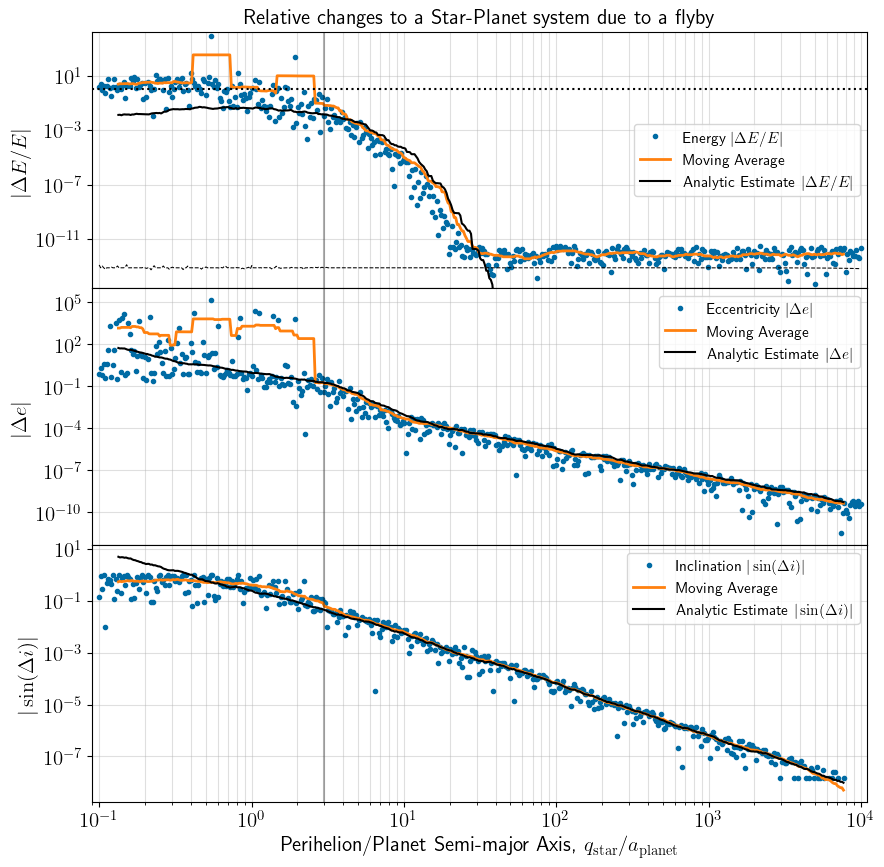

In [6]:
n = 25
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(3,1, figsize=(10,10), sharex=True)
ax[0].set_title('Relative changes to a Star-Planet system due to a flyby', font={'size':15})

ax[0].loglog(qda, dE, 'C0.', label=r'Energy $|\Delta E/E|$')
ax[0].loglog(ma(qda, n), ma(dE, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[0].loglog(ma(qda,n), ma(est_dE,n, 'nan'), 'k-', label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].loglog(qda, 2.0**(-53.0) * np.sqrt(nsteps), 'k--', lw=0.75)
ax[0].axhline(y=1, ls=':', c='k')
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(qda)*0.9, np.max(qda)*1.1])
ax[0].set_ylim([np.min(dE)/2, np.max(dE)*2])

ax[1].loglog(qda, de, 'C0.', label=r'Eccentricity $|\Delta e|$')
ax[1].loglog(ma(qda, n), ma(de, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[1].loglog(ma(qda,n), ma(est_de,n, 'nan'), 'k-', label=r'Analytic Estimate $|\Delta e|$')
ax[1].set_ylabel(r'$|\Delta e|$')

ax[2].loglog(qda, di, 'C0.', label=r'Inclination $|\sin(\Delta i)|$')
ax[2].loglog(ma(qda, n), ma(di, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[2].loglog(ma(qda,n), ma(est_di,n, 'nan'), 'k-', label=r'Analytic Estimate $|\sin(\Delta i)|$')
ax[2].set_ylabel(r'$|\sin(\Delta i)|$')
ax[2].set_xlabel(r'Perihelion/Planet Semi-major Axis, $q_\mathrm{star}/a_\mathrm{planet}$')

for i in range(3):
    ax[i].axvline(3, c='k', alpha=0.3)
    ax[i].legend(prop={'size': 11})
    ax[i].xaxis.grid(True, which='both', alpha=0.4)
    ax[i].yaxis.grid(True, which='both', alpha=0.4)

plt.subplots_adjust(hspace=0.)
plt.show()

We can see that the adiabatic analytical estimates begin to diverge from the numerical values given by `airball` and `rebound` when the flyby stars are no longer in the adiabatic regime around $q_\mathrm{star}/a_\mathrm{planet} \sim 3$. Additionally, there is a dramatic divergence when the relative change in energy reaches the numerical floating point precision floor.

#### `StellarEnvironment.maximum_impact_parameter`
When initializing a [Stellar Environment](examples/stellar-environments/) a value can either be given for the `maximum_impact_parameter`, but if it is not specified it will also be estimated. Physically, there is no maximum distance that limits the gravitational influence of passing stars, but as can be seen in the figure above, there is a numerical limit beyond which changes to the energy of the system are no longer resolved. Thus, when the `maximum_impact_parameter` is not specified, `AIRBALL` will estimate its value by finding the distance where the relative energy change from a typical flyby drops below $10^{-16}$.

### Investigate the effects from a flyby with respect to velocity.

The adiabatic effects of a stellar flyby on a star-planet not only depends on the perihelion distance, but also the velocity. We can investigate this by running a couple hundred flyby scenarios while systematically changing the velocity of the stars at infinity while fixing the perihelion distance. If each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters.

The following takes about 10 seconds to run on an M2 Pro Macbook Pro

In [7]:
Nflybys = 500

qFrac = 10
planet_v = (sim.particles[1].v * u.au/u.yr2pi).to(u.km/u.s) # planet's orbital velocity in km/s
star_vs = np.logspace(np.log10(planet_v.value * 1e-2), np.log10(planet_v.value * 1e2), Nflybys)
star_bs = airball.tools.vinf_and_q_to_b(mu = airball.tools.gravitational_mu(sim, star), star_q = qFrac * planet_a, star_v=star_vs)

sims = [setup() for i in range(Nflybys)]
stars = airball.Stars(m=star.m, b=star_bs, v=star_vs)
vs_v = stars.v/planet_v
RMAX = 1e5*u.au

sim_results = airball.flybys(sims, stars, hybrid=True, rmax=RMAX, overwrite=False)

est_dE = np.abs(airball.analytic.relative_energy_change(setup(), stars))
est_de = np.abs(airball.analytic.eccentricity_change_adiabatic_estimate(setup(), stars, rmax=RMAX))
est_di = np.abs(airball.analytic.inclination_change_adiabatic_estimate(setup(), stars))

dE,de,di = np.zeros(Nflybys), np.zeros(Nflybys), np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)
for i in range(Nflybys):
    de[i] = np.abs(sim_results[i].particles[1].e - sims[i].particles[1].e)
    di[i] = np.abs(np.sin(sim_results[i].particles[1].inc - sims[i].particles[1].inc))
    dE[i] = np.abs((sim_results[i].energy()-sims[i].energy())/sims[i].energy())
    nsteps[i] = sim_results[i].steps_done

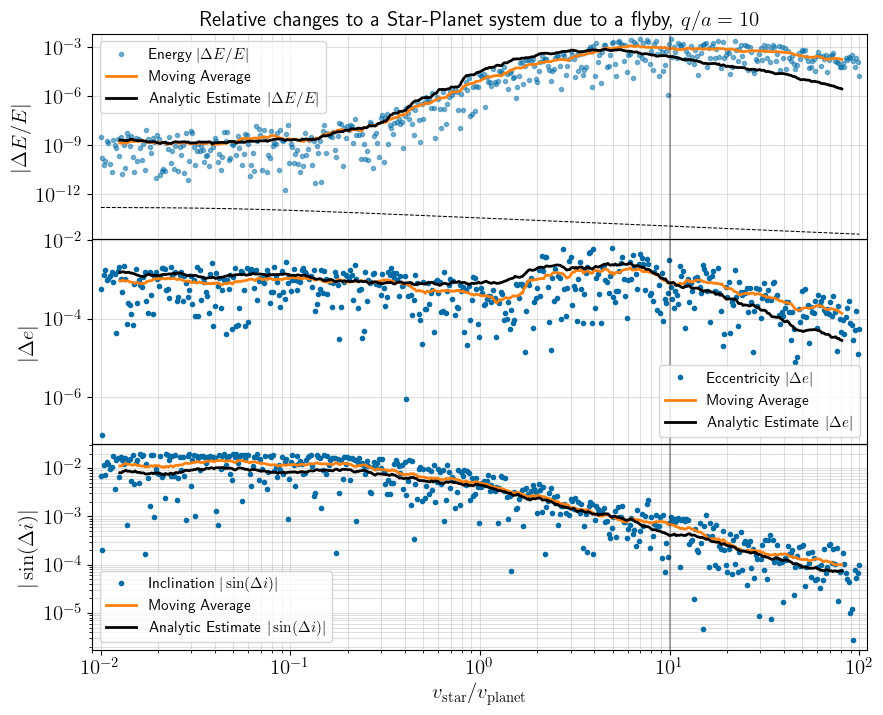

In [8]:
floor = 2.0**(-53.0) * np.sqrt(nsteps)
n = 25
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].set_title(rf'Relative changes to a Star-Planet system due to a flyby, $q/a={{{qFrac}}}$', font={'size':15})

ax[0].loglog(vs_v, dE, 'C0.', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].loglog(ma(vs_v, n=n), ma(dE, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[0].loglog(ma(vs_v, n), ma(est_dE, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].loglog(vs_v, floor, 'k--', lw=0.75)
ax[0].axhline(y=1, ls=':', c='k')
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(vs_v)*0.9, np.max(vs_v)*1.1])
ax[0].set_ylim([np.min([dE, floor])/2, np.max(dE)*2])

ax[1].loglog(vs_v, de, 'C0.', label=r'Eccentricity $|\Delta e|$')
ax[1].loglog(ma(vs_v, n), ma(de, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[1].loglog(ma(vs_v, n), ma(est_de, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta e|$')
ax[1].set_ylabel(r'$|\Delta e|$')

ax[2].loglog(vs_v, di, 'C0.', label=r'Inclination $|\sin(\Delta i)|$')
ax[2].loglog(ma(vs_v, n), ma(di, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[2].loglog(ma(vs_v, n), ma(est_di, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\sin(\Delta i)|$')
ax[2].set_ylabel(r'$|\sin(\Delta i)|$')
ax[2].set_xlabel(r'$v_\mathrm{star}/v_\mathrm{planet}$')

for i in range(3):
    ax[i].axvline(10, c='k', alpha=0.3)
    ax[i].legend(prop={'size': 11})
    ax[i].xaxis.grid(True, which='both', alpha=0.4)
    ax[i].yaxis.grid(True, which='both', alpha=0.4)

plt.subplots_adjust(hspace=0.)
plt.show()

We again can see that the adiabatic analytical estimates begin to diverge from the numerical values given when the flyby stars are no longer in the adiabatic regime around $v_\mathrm{star}/v_\mathrm{planet} \sim 10$.

### Investigate the effects from a flyby with respect to mass.

The adiabatic effects of a stellar flyby on a star-planet not only depends on the perihelion distance and the velocity, but also on the mass of the star. We can investigate this by running a couple hundred flyby scenarios while systematically changing the mass of the stars from jupiter mass to very massive for a fixed perihelion distance. If each time we have a different, randomly oriented flyby with a random velocity, we can also obtain a statistical idea of how much the orientation matters.

The following takes about 10 seconds to run on an M2 Pro Macbook Pro

In [9]:
Nflybys = 500

def loguniform(x):
    '''Sample log-uniformly'''
    return 1/x

qs = 500 * np.ones(Nflybys) << u.au
vs = airball.tools.maxwell.rvs(scale=airball.tools.maxwell_boltzmann_scale_from_dispersion(5), size=Nflybys) << u.km/u.s
imf = airball.IMF(1e-3, 1e2, number_samples=50, mass_function=loguniform)
ms = imf.random_mass(Nflybys)
mu = airball.tools.gravitational_mu(sim, star_mass=ms)
bs = airball.tools.vinf_and_q_to_b(mu, qs, vs)
stars = airball.Stars(m=ms, b=bs, v=vs)
stars.sort('m')
masses = stars.m

RMAX = 4.5e5*u.au

sim_results = airball.flybys(sims, stars, hybrid=True, rmax=RMAX, overwrite=False)

est_dE = np.abs(airball.analytic.relative_energy_change(setup(), stars))
est_de = np.abs(airball.analytic.eccentricity_change_adiabatic_estimate(setup(), stars, rmax=RMAX))
est_di = np.abs(airball.analytic.inclination_change_adiabatic_estimate(setup(), stars))

dE,de,di = np.zeros(Nflybys), np.zeros(Nflybys), np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)
for i in range(Nflybys):
    de[i] = np.abs(sim_results[i].particles[1].e - sims[i].particles[1].e)
    di[i] = np.abs(np.sin(sim_results[i].particles[1].inc - sims[i].particles[1].inc))
    dE[i] = np.abs((sim_results[i].energy()-sims[i].energy())/sims[i].energy())
    nsteps[i] = sim_results[i].steps_done

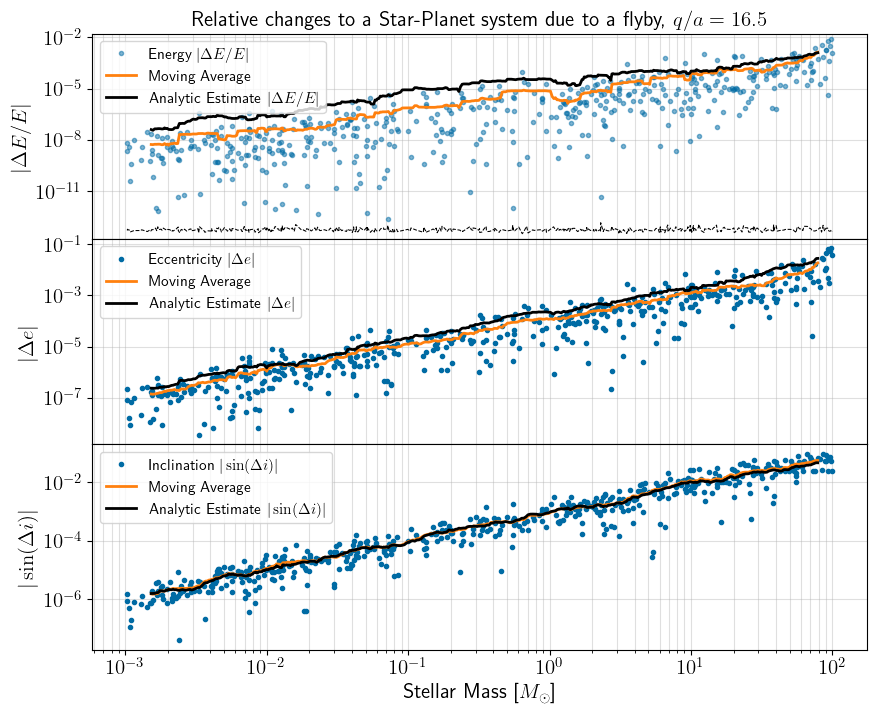

In [10]:
floor = 2.0**(-53.0) * np.sqrt(nsteps)
n = 25
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].set_title(rf'Relative changes to a Star-Planet system due to a flyby, $q/a={{{np.mean(qs/planet_a):1.1f}}}$', font={'size':15})

ax[0].loglog(masses, dE, 'C0.', alpha=0.5, label=r'Energy $|\Delta E/E|$')
ax[0].loglog(ma(masses, n), ma(dE, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[0].loglog(ma(masses, n), ma(est_dE, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].loglog(masses, floor, 'k--', lw=0.75)
ax[0].axhline(y=1, ls=':', c='k')
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_ylim([np.min([dE, floor])/2, np.max(dE)*2])

ax[1].loglog(masses, de, 'C0.', label=r'Eccentricity $|\Delta e|$')
ax[1].loglog(ma(masses, n), ma(de, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[1].loglog(ma(masses, n), ma(est_de, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta e|$')
ax[1].set_ylabel(r'$|\Delta e|$')

ax[2].loglog(masses, di, 'C0.', label=r'Inclination $|\sin(\Delta i)|$')
ax[2].loglog(ma(masses, n), ma(di, n, 'nan'), 'C1-', lw=2, label='Moving Average')
ax[2].loglog(ma(masses, n), ma(est_di, n, 'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\sin(\Delta i)|$')
ax[2].set_ylabel(r'$|\sin(\Delta i)|$')
ax[2].set_xlabel(r'Stellar Mass [$M_\odot$]')

for i in range(3):
    ax[i].legend(prop={'size': 11})
    ax[i].xaxis.grid(True, which='both', alpha=0.4)
    ax[i].yaxis.grid(True, which='both', alpha=0.4)

plt.subplots_adjust(hspace=0.)
plt.show()

### Investigate the effects from a flyby with respect to starting distance.

Numerical artifacts can arise if we are not careful when considering an appropriate starting distance for the stellar flyby. We can investigate this by running a couple hundred flyby scenarios while systematically changing the starting distance. Additionally, if each time we have a different, randomly oriented flyby, we can also obtain a statistical idea of how much the orientation matters. It is important to choose an appropriate perihelion for the flyby star. By referring back to the figure showing the relative change in energy with respect to the perihelion distance, we can choose a point where the average numerical relative change in energy just begins to diverge from the average adiabatic analytical estimate at the cusp of the numerical floor. At this inflection point we will be sensitive enough to distinguish between changes in the relative change in energy from the perihelion of the flyby star and the starting distance of the star. After some guess and check, $q_\mathrm{star}/a_\mathrm{planet} \sim 26$ seems to provide the best value to work with.

The following takes about 10 seconds to run on an M2 Pro Macbook Pro

In [11]:
Nflybys = 500

sims = [setup() for i in range(Nflybys)]
star_b = airball.tools.vinf_and_q_to_b(mu = airball.tools.gravitational_mu(sim, star), star_q = 26 * planet_a, star_v=star.v)
stars = airball.Stars(m=star.m, b=star_b, v=star.v, size=Nflybys)
rmaxes = np.logspace(3, 6.5, Nflybys) << u.au

sim_results = airball.flybys(sims, stars, hybrid=True, rmax=rmaxes, overwrite=False)

est_dE = np.abs(airball.analytic.relative_energy_change(setup(), stars))
est_de = np.abs(airball.analytic.eccentricity_change_adiabatic_estimate(setup(), stars, rmax=rmaxes))
est_di = np.abs(airball.analytic.inclination_change_adiabatic_estimate(setup(), stars))

dE,de,di = np.zeros(Nflybys), np.zeros(Nflybys), np.zeros(Nflybys)
nsteps = np.zeros(Nflybys)
for i in range(Nflybys):
    de[i] = np.abs(sim_results[i].particles[1].e - sims[i].particles[1].e)
    di[i] = np.abs(np.sin(sim_results[i].particles[1].inc - sims[i].particles[1].inc))
    dE[i] = np.abs((sim_results[i].energy()-sims[i].energy())/sims[i].energy())
    nsteps[i] = sim_results[i].steps_done

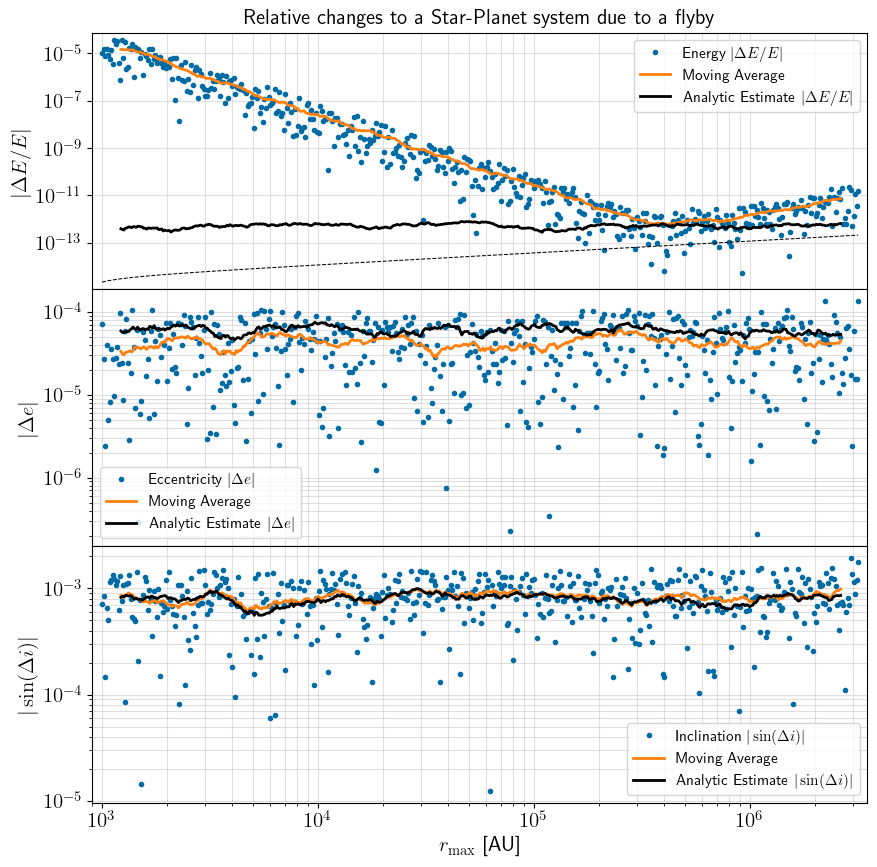

In [12]:
floor = 2.0**(-53.0) * np.sqrt(nsteps)
n = 25
plt.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(3,1, figsize=(10,10), sharex=True)
ax[0].set_title(rf'Relative changes to a Star-Planet system due to a flyby', font={'size':15})

ax[0].loglog(rmaxes, dE, 'C0.', label=r'Energy $|\Delta E/E|$')
ax[0].loglog(ma(rmaxes, n), ma(dE, n,'nan'), 'C1-', lw=2, label='Moving Average')
ax[0].loglog(ma(rmaxes,n), ma(est_dE,n,'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta E/E|$')
ax[0].loglog(rmaxes, floor, 'k--', lw=0.75)
ax[0].axhline(y=1, ls=':', c='k')
ax[0].set_ylabel(r'$|\Delta E/E|$')
ax[0].set_xlim([np.min(rmaxes.value)*0.9, np.max(rmaxes.value)*1.1])
ax[0].set_ylim([np.min([dE, floor])/2, np.max(dE)*2])

ax[1].loglog(rmaxes, de, 'C0.', label=r'Eccentricity $|\Delta e|$')
ax[1].loglog(ma(rmaxes, n), ma(de, n,'nan'), 'C1-', lw=2, label='Moving Average')
ax[1].loglog(ma(rmaxes,n), ma(est_de,n,'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\Delta e|$')
ax[1].set_ylabel(r'$|\Delta e|$')

ax[2].loglog(rmaxes, di, 'C0.', label=r'Inclination $|\sin(\Delta i)|$')
ax[2].loglog(ma(rmaxes, n), ma(di, n,'nan'), 'C1-', lw=2, label='Moving Average')
ax[2].loglog(ma(rmaxes,n), ma(est_di,n,'nan'), 'k-', lw=2, label=r'Analytic Estimate $|\sin(\Delta i)|$')
ax[2].set_ylabel(r'$|\sin(\Delta i)|$')
ax[2].set_xlabel(r'$r_{\mathrm{max}}$ [AU]')

for i in range(3):
    ax[i].legend(prop={'size': 11})
    ax[i].xaxis.grid(True, which='both', alpha=0.4)
    ax[i].yaxis.grid(True, which='both', alpha=0.4)

plt.subplots_adjust(hspace=0.)
plt.show()